The UNSW-NB15 dataset contains modern network traffic that includes both normal activity and nine different types of attacks such as Fuzzers, DoS, Backdoor, Exploits, and Worms. This diversity makes it suitable for training ML models that detect real-world intrusions.

Missing values in train (top 20):
Series([], dtype: int64)

Missing values in test (top 20):
Series([], dtype: int64)


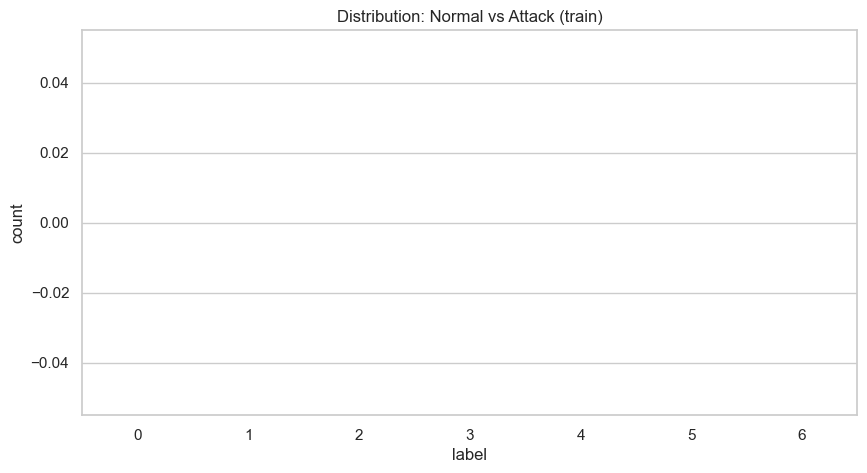

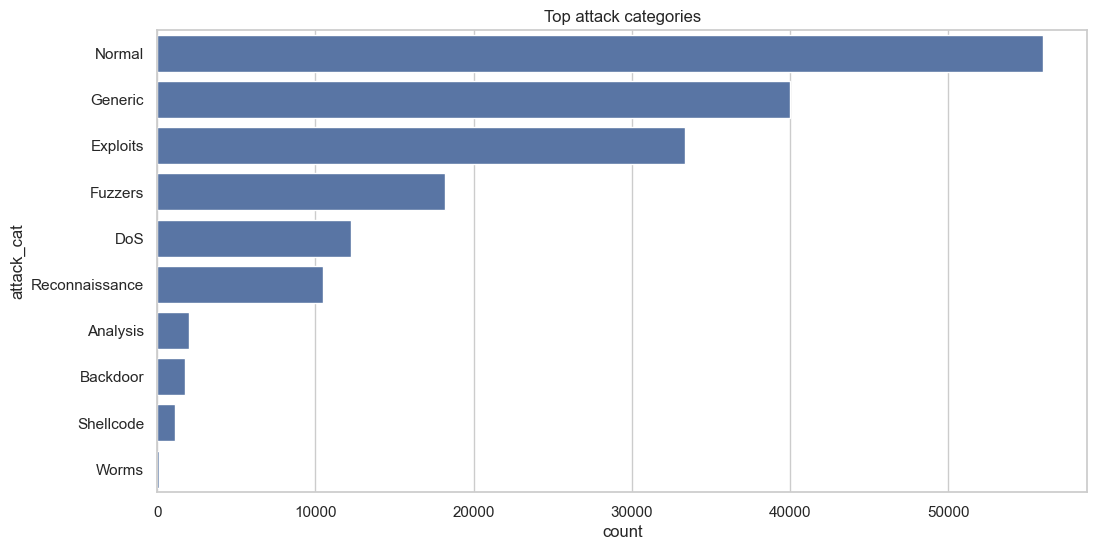


Preprocessing and EDA cell finished.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import os

# --- Load the datasets (use raw strings to avoid unicode escape issues) ---
train_path = r"C:\Users\user\Documents\GitHub\CLO4-IDS-ML-Solution\dataset 2\UNSW-NB15\UNSW_NB15_training-set.csv"
test_path = r"C:\Users\user\Documents\GitHub\CLO4-IDS-ML-Solution\dataset 2\UNSW-NB15\UNSW_NB15_testing-set.csv"

if not (os.path.exists(train_path) and os.path.exists(test_path)):
    print('Warning: train or test CSV not found. Please verify the paths:')
    print('  ', train_path)
    print('  ', test_path)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# --- Check for missing values ---
print('Missing values in train (top 20):')
print(train_df.isnull().sum().loc[lambda s: s>0].head(20))
print('\nMissing values in test (top 20):')
print(test_df.isnull().sum().loc[lambda s: s>0].head(20))

# Fill missing numeric values with median (exclude the target 'label' from numeric preprocessing)
num_features = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Remove the target column from numeric feature list so we don't impute/scale it
num_features = [c for c in num_features if c != 'label']
imputer = SimpleImputer(strategy='median')
train_df[num_features] = imputer.fit_transform(train_df[num_features])
test_df[num_features] = imputer.transform(test_df[num_features])

# --- Encode categorical features (safer per-column encoder) ---
cat_features = [c for c in ['proto', 'service', 'state'] if c in train_df.columns]
label_encoders_local = {}
for col in cat_features:
    le_col = LabelEncoder()
    combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)], axis=0)
    le_col.fit(combined)
    train_df[col] = le_col.transform(train_df[col].astype(str))
    test_df[col] = le_col.transform(test_df[col].astype(str))
    label_encoders_local[col] = le_col

# --- Normalize numeric features (keep target untouched) ---
scaler = StandardScaler()
train_df[num_features] = scaler.fit_transform(train_df[num_features])
test_df[num_features] = scaler.transform(test_df[num_features])

# --- Separate features and labels (drop identifier/label columns from features) ---
drop_cols = [c for c in ['id', 'attack_cat', 'label'] if c in train_df.columns]
# Drop the target from the feature dataframe so X_train doesn't contain 'label'
X_train = train_df.drop(columns=drop_cols, errors='ignore')
# Keep target as integer (discrete) — important for classifiers
y_train = train_df['label'].astype(int) if 'label' in train_df.columns else None

drop_cols_test = [c for c in ['id', 'attack_cat', 'label'] if c in test_df.columns]
X_test = test_df.drop(columns=drop_cols_test, errors='ignore')
y_test = test_df['label'].astype(int) if 'label' in test_df.columns else None

if y_train is None:
    raise KeyError("Target column 'label' not found in training data. Check dataset columns.")

# --- EDA: Visualizing class imbalance ---
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
if y_train.nunique() == 2:
    sns.countplot(x=y_train.map({0:'Normal', 1:'Attack'}))
    plt.title("Distribution: Normal vs Attack (train)")
else:
    sns.countplot(x=y_train)
    plt.title("Label distribution (train)")
plt.show()

# Attack category distribution if present
if 'attack_cat' in train_df.columns:
    plt.figure(figsize=(12,6))
    sns.countplot(y='attack_cat', data=train_df, order=train_df['attack_cat'].value_counts().index[:30])
    plt.title('Top attack categories')
    plt.show()

print('\nPreprocessing and EDA cell finished.')


In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
clf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    random_state=42,
    class_weight='balanced'  # handle imbalanced data
)

# Train the model
clf.fit(X_train, y_train)

print("Random Forest model trained successfully!")


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.